# Alt SVM generation of datas

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import shutil
import time
import os
import subprocess
import webbrowser

# shutil.rmtree('runs', ignore_errors=True)

def generate_embeddings(n, m, d, device):
    """
    Generates random user (U) and item (V) embeddings for matrix factorization.
    - Normal distribution (mean 0, variance 1) for U and V

    Parameters:
    n (int): Number of users.
    m (int): Number of items.
    d (int): Latent dimension (embedding size).
    device (torch.device): The device where tensors will be stored (CPU/GPU).

    Returns:
    tuple: User embeddings U (n x d) and item embeddings V (m x d).
    """
    
    # Convert d to a tensor for numerical stability
    d_tensor = torch.tensor(d, dtype=torch.float32)

    # Initialize user embeddings (U) and item embeddings (V) with random values
    # Normalize by sqrt(d) to keep variance stable
    U = torch.randn(n, d, device=device) / torch.sqrt(d_tensor)
    V = torch.randn(m, d, device=device) / torch.sqrt(d_tensor)

    # Center the item embeddings by subtracting the mean per row
    V -= torch.mean(V, dim=1, keepdim=True)

    return U, V


def split_dataset(dataset, num_datapoints, train_ratio=0.8, val_ratio=0.1, batch_size=64):
    """
    Splits a dataset into training, validation, and test sets and creates DataLoaders.
    - Split by random_split

    Parameters:
    dataset (torch.utils.data.Dataset): The dataset to be split.
    num_datapoints (int): Total number of datapoints in the dataset.
    train_ratio (float, optional): Proportion of data to use for training (default: 0.8).
    val_ratio (float, optional): Proportion of data to use for validation (default: 0.1).
    batch_size (int, optional): Batch size for DataLoader (default: 64).

    Returns:
    tuple: DataLoaders for training, validation, and test sets.
    """

    # Compute dataset sizes for each split
    train_size = int(train_ratio * num_datapoints)
    val_size = int(val_ratio * num_datapoints)
    test_size = num_datapoints - train_size - val_size  # Ensure all datapoints are used

    # Split the dataset into train, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders for each dataset split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def start_tensorboard(log_dir='runs/matrix_factorization', port=6006):
    """Starts TensorBoard and opens it in the default web browser."""
    # Remove old logs
    shutil.rmtree(log_dir, ignore_errors=True)
    
    # Launch TensorBoard in the background
    subprocess.Popen(["tensorboard", "--logdir=runs", f"--port={port}"], 
                     stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    # Wait for TensorBoard to start
    time.sleep(3)
    
    # Open TensorBoard in the browser
    webbrowser.open(f"http://localhost:{port}/")
    print(f"🔥 TensorBoard launched at http://localhost:{port}/")

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=100, is_last=False):
    """
    Trains a matrix factorization model using binary cross-entropy loss.

    Parameters:
    model (torch.nn.Module): The model to be trained.
    train_loader (DataLoader): DataLoader for the training dataset.
    val_loader (DataLoader): DataLoader for the validation dataset.
    optimizer (torch.optim.Optimizer): Optimizer used for training.
    device (torch.device): Device (CPU or GPU) where training will occur.
    num_epochs (int, optional): Number of epochs for training (default: 100).

    Returns:
    None
    """

    # Define logging directory for TensorBoard and reset previous logs
    if is_last:
        log_dir = 'runs/matrix_factorization'
        start_tensorboard(log_dir=log_dir)
        writer = SummaryWriter(log_dir=log_dir)


    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_loss = 0
        model.train()  # Set model to training mode

        # Iterate through training batches
        for batch in train_loader:
            u, i, j, z = [x.to(device) for x in batch]  # Move batch data to device
            optimizer.zero_grad()  # Reset gradients
            pred = model(u, i, j)  # Forward pass
            loss = F.binary_cross_entropy(pred, z.float())  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            total_loss += loss.item()  # Accumulate loss

        # Log training loss to TensorBoard
        if is_last:
            writer.add_scalar('Loss/train', total_loss / len(train_loader), epoch)

        # Validation phase
        val_loss = 0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                u, i, j, z = [x.to(device) for x in batch]
                pred = model(u, i, j)
                loss = F.binary_cross_entropy(pred, z.float())
                val_loss += loss.item()

        # Log validation loss to TensorBoard
        if is_last:
            writer.add_scalar('Loss/val', val_loss / len(val_loader), epoch)


    writer.close()  # Close TensorBoard writer


def evaluate_model(model, test_loader, device):
    """
    Evaluates a trained model on the test dataset.

    Parameters:
    model (torch.nn.Module): The trained model to evaluate.
    test_loader (DataLoader): DataLoader for the test dataset.
    device (torch.device): Device (CPU or GPU) where evaluation will occur.

    Returns:
    tuple: Average test loss and accuracy of the model.
    """

    model.eval()  # Set model to evaluation mode
    test_loss, correct, total = 0, 0, 0  # Initialize tracking variables

    # Disable gradient calculations for efficiency
    with torch.no_grad():
        for batch in test_loader:
            u, i, j, z = [x.to(device) for x in batch]  # Move batch data to device

            # Forward pass
            pred = model(u, i, j)
            loss = F.binary_cross_entropy(pred, z.float())  # Compute loss
            test_loss += loss.item()

            # Convert probabilities to binary predictions (threshold at 0.5)
            pred = (pred > 0.5).float()

            # Count correct predictions
            correct += (pred == z).sum().item()
            total += len(z)

    # Compute accuracy
    accuracy = correct / total if total > 0 else 0.0

    return test_loss / len(test_loader), accuracy


def compute_reconstruction_error(model, U, V, scale):
    """
    Computes the reconstruction error of the matrix factorization model.

    Parameters:
    model (torch.nn.Module): The trained model containing learned user (U) and item (V) embeddings.
    U (torch.Tensor): Ground truth user embeddings (size: n x d).
    V (torch.Tensor): Ground truth item embeddings (size: m x d).
    scale (float): Scaling factor applied to the ground truth embeddings.

    Returns:
    float: Mean squared error (MSE) between the reconstructed matrix and the ground truth.
    """

    # Compute the reconstructed user-item matrix from learned embeddings
    user_item_matrix = torch.mm(model.U, model.V.t())

    # Center the reconstructed matrix by subtracting the mean of each row
    user_item_matrix -= torch.mean(user_item_matrix, dim=1, keepdim=True)

    # Compute Mean Squared Error (MSE) between reconstructed and scaled ground truth matrix
    reconstruction_error = F.mse_loss(user_item_matrix, scale * torch.mm(U, V.t()))

    return reconstruction_error.item()  # Return as a Python float

def compute_ground_truth_metrics(test_loader, U, V, device):
    """
    Computes ground truth metrics (MSE loss and accuracy) using pre-trained embeddings.

    Parameters:
    test_loader (DataLoader): DataLoader for the test dataset.
    U (torch.Tensor): Ground truth user embeddings (size: n x d).
    V (torch.Tensor): Ground truth item embeddings (size: m x d).
    device (torch.device): Device (CPU or GPU) where computation will occur.

    Returns:
    tuple: Mean squared error (MSE) loss and accuracy based on ground truth embeddings.
    """

    gt_loss, gt_correct, gt_total = 0, 0, 0  # Initialize tracking variables

    # Disable gradient calculations for efficiency
    with torch.no_grad():
        for batch in test_loader:
            u, i, j, z = [x.to(device) for x in batch]  # Move batch data to device

            # Retrieve user embeddings and compute item difference
            user_embeddings = U[u]  # Select user embeddings based on indices
            item_diff = V[i] - V[j]  # Compute item pairwise differences

            # Compute probability using sigmoid function
            gt_prob = torch.sigmoid(torch.sum(user_embeddings * item_diff, dim=1))

            # Compute Mean Squared Error (MSE) loss
            loss = F.mse_loss(gt_prob, z.float())
            gt_loss += loss.item()

            # Convert predictions to binary labels (threshold at 0)
            gt_pred = (torch.sum(user_embeddings * item_diff, dim=1) > 0).float()

            # Count correct predictions
            gt_correct += (gt_pred == z).sum().item()
            gt_total += len(z)

    # Compute accuracy
    gt_accuracy = gt_correct / gt_total if gt_total > 0 else 0.0

    return gt_loss / len(test_loader), gt_accuracy


class BTLPreferenceDataset(Dataset):
    """
    Bradley-Terry-Luce (BTL) preference dataset for training matrix factorization models.

    This dataset generates user-item preference comparisons based on the BTL model.

    Parameters:
    U (torch.Tensor): User embeddings matrix (size: n_users x d).
    V (torch.Tensor): Item embeddings matrix (size: m_items x d).
    num_datapoints (int): Number of preference samples to generate.
    scale (float, optional): Scaling factor for preference scores (default: 1.0).

    Methods:
    - generate_preferences(num_datapoints): Generates pairwise preference data.
    - __len__(): Returns the number of datapoints.
    - __getitem__(idx): Retrieves a specific datapoint.

    Returns:
    - A PyTorch Dataset containing tuples (user_id, item_i, item_j, preference_label).
    """

    def __init__(self, U, V, num_datapoints, scale=1.0):
        self.U = U  # User embeddings
        self.V = V  # Item embeddings
        self.scale = scale  # Scaling factor for preference scores
        self.data = self.generate_preferences(num_datapoints)  # Generate dataset

    def generate_preferences(self, num_datapoints):
        """
        Generates pairwise preferences based on the Bradley-Terry-Luce (BTL) model.

        Parameters:
        num_datapoints (int): Number of preference samples to generate.

        Returns:
        list: A list of tuples (user_id, item_i, item_j, preference_label).
        """

        n_users, d = self.U.shape  # Number of users and embedding dimension
        m_items, _ = self.V.shape  # Number of items
        data = []

        for _ in range(num_datapoints):
            # Randomly select a user
            u = torch.randint(0, n_users, (1,)).item()

            # Randomly select two different items
            i, j = torch.randint(0, m_items, (2,)).tolist()
            while i == j:  # Ensure i and j are not the same item
                j = torch.randint(0, m_items, (1,)).item()

            # Compute preference score using the BTL model
            user_embedding = self.U[u]  # Retrieve user embedding
            item_diff = self.V[i] - self.V[j]  # Compute item difference
            preference_score = torch.sigmoid(self.scale * torch.dot(user_embedding, item_diff))

            # Assign label: 1 if user prefers item i over j, else 0
            label = torch.bernoulli(preference_score).item()  # Sample from Bernoulli distribution
            data.append((u, i, j, label))

        return data

    def __len__(self):
        """Returns the total number of datapoints in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Retrieves a specific preference datapoint."""
        return self.data[idx]

class MatrixFactorization(nn.Module):
    """
    Matrix Factorization model using user and item embeddings with dropout regularization.

    This model is based on the Bradley-Terry-Luce (BTL) preference model, where a user 
    is given two items (i and j), and the model predicts the probability that the user 
    prefers item i over item j.

    Parameters:
    n_users (int): Number of users.
    n_items (int): Number of items.
    d (int): Latent dimension size for embeddings.

    Methods:
    - forward(u, i, j): Computes the preference probability between two items for a user.

    Returns:
    - A probability score (between 0 and 1) indicating the preference of item i over item j.
    """

    def __init__(self, n_users, n_items, d):
        super(MatrixFactorization, self).__init__()

        # Initialize user and item embeddings with normalized random values
        self.U = nn.Parameter(torch.randn(n_users, d) / torch.sqrt(torch.tensor(d, dtype=torch.float32)))
        self.V = nn.Parameter(torch.randn(n_items, d) / torch.sqrt(torch.tensor(d, dtype=torch.float32)))

    def forward(self, u, i, j):
        """
        Forward pass for computing preference scores using the BTL model.

        Parameters:
        u (torch.Tensor): Tensor of user indices.
        i (torch.Tensor): Tensor of first item indices.
        j (torch.Tensor): Tensor of second item indices.

        Returns:
        torch.Tensor: Probability score indicating preference of item i over item j.
        """

        # Retrieve user and item embeddings with dropout applied
        u_embedding = self.U[u]  # User embedding
        i_embedding = self.V[i]  # Item i embedding
        j_embedding = self.V[j]  # Item j embedding

        # Compute the difference between items i and j
        diff = torch.sum(u_embedding * (i_embedding - j_embedding), dim=1)

        # Apply sigmoid activation to get a probability score (between 0 and 1)
        return torch.sigmoid(diff)



def run_experiment(n, m, d, p, s, device, reps=5, **kwargs):
    """
    Runs multiple experiments for matrix factorization with BTL preference data.

    Parameters:
    n (int): Number of users.
    m (int): Number of items.
    d (int): Latent dimension size for embeddings.
    p (float): Proportion of user-item interactions used as datapoints.
    s (float): Scaling factor for preference scores.
    device (torch.device): The device (CPU/GPU) where computations will occur.
    reps (int, optional): Number of repetitions for the experiment (default: 5).
    **kwargs: Additional keyword arguments.

    Returns:
    tuple: Lists containing reconstruction errors, log likelihoods, accuracy,
           ground truth log likelihoods, and ground truth accuracy.
    """

    # Compute total number of preference datapoints
    num_datapoints = int(n * m * p / 2)

    # Store results across multiple repetitions
    reconstruction_errors, log_likelihoods, accuracy = [], [], []
    gt_accuracy, gt_log_likelihoods = [], []

    for rep in range(reps):
        start_time = time.time()
        print(f"\n### Experiment {rep+1}/{reps} started... ###")

        # Step 1: Generate embeddings
        U, V = generate_embeddings(n, m, d, device)

        # Step 2: Create preference dataset
        dataset = BTLPreferenceDataset(U, V, num_datapoints, scale=s)

        # Step 3: Split dataset into train, validation, and test sets
        train_loader, val_loader, test_loader = split_dataset(dataset, num_datapoints)

        # Step 4: Initialize the matrix factorization model
        model = MatrixFactorization(n, m, d).to(device)

        # Step 5: Define optimizer (Adam with weight decay for regularization)
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-3)

        # Step 6: Train the model
        train_start_time = time.time()
        is_last = rep == reps - 1
        train_model(model, train_loader, val_loader, optimizer, device, is_last=is_last)
        print(f"Epoch {rep+1}: Training completed in {time.time() - train_start_time:.4f} seconds")

        # Step 7: Evaluate the model on the test set
        test_loss, test_accuracy = evaluate_model(model, test_loader, device)

        # Step 8: Compute reconstruction error
        reconstruction_error = compute_reconstruction_error(model, U, V, s)

        # Step 9: Compute ground truth metrics
        gt_loss, gt_acc = compute_ground_truth_metrics(test_loader, U, V, device)

        # Store results for this repetition
        reconstruction_errors.append(reconstruction_error)
        log_likelihoods.append(-test_loss)
        accuracy.append(test_accuracy)
        gt_log_likelihoods.append(-gt_loss)
        gt_accuracy.append(gt_acc)

        print(f"### Experiment {rep+1}/{reps} completed in {time.time() - start_time:.4f} seconds ###")

    return reconstruction_errors, log_likelihoods, accuracy, gt_log_likelihoods, gt_accuracy


In [47]:
# Set experiment parameters
n_users = 100   # Number of users
m_items = 200   # Number of items
embedding_dim = 20  # Latent dimension size
pairwise_density = 0.5  # How many comparisons exist
scale_factor = 2.0  # BTL scale factor
reps = 1  # Number of repetitions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# Run the experiment
reconstruction_errors, log_likelihoods, accuracy, gt_log_likelihoods, gt_accuracy = run_experiment(
    n_users, m_items, embedding_dim, pairwise_density, scale_factor, device, reps
)
print("\n\nResults:")
# Print final results
# Define the results
results = {
    "Reconstruction Errors": reconstruction_errors,
    "Log Likelihoods": log_likelihoods,
    "Accuracies": accuracy,
    "Ground Truth Log Likelihoods": gt_log_likelihoods,
    "Ground Truth Accuracies": gt_accuracy
}

# Find the longest key for alignment
max_key_length = max(len(key) for key in results.keys())

# Print aligned output
for key, value in results.items():
    print(f"{key.ljust(max_key_length)}: {value}")



### Experiment 1/1 started... ###
🔥 TensorBoard launched at http://localhost:6006/


Training Progress: 100%|██████████| 100/100 [00:09<00:00, 10.64it/s]

Epoch 1: Training completed in 12.5140 seconds
### Experiment 1/1 completed in 12.7934 seconds ###


Results:
Reconstruction Errors       : [0.19292473793029785]
Log Likelihoods             : [-0.693147175014019]
Accuracies                  : [0.506]
Ground Truth Log Likelihoods: [-0.22925668954849243]
Ground Truth Accuracies     : [0.652]


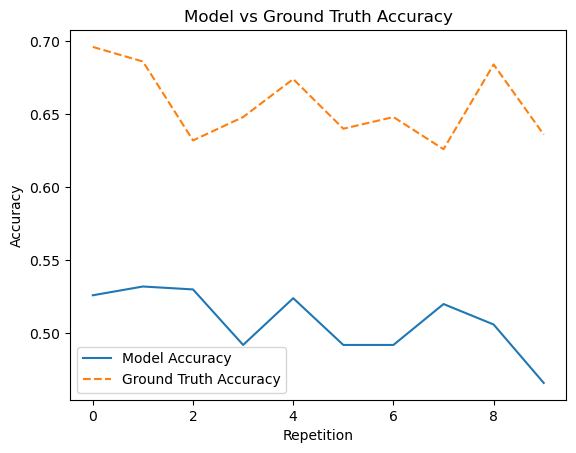

In [35]:
import matplotlib.pyplot as plt

# Plot accuracy over repetitions
plt.plot(accuracy, label="Model Accuracy")
plt.plot(gt_accuracy, label="Ground Truth Accuracy", linestyle="--")
plt.xlabel("Repetition")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model vs Ground Truth Accuracy")
plt.show()
